In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import corner
import wquantiles

In [62]:
def log2linear_weight(value, pmin, pmax):
    mask = np.logical_and(value>=pmin, value<=pmax)
    uniform_prior = 1 / (pmax-pmin)
    linexp_prior = np.log(10) * 10**value / (10**pmax - 10**pmin)
    
    weight = mask * linexp_prior / uniform_prior
    weight /= sum(weight)

    return weight

In [39]:
prior_chain = np.genfromtxt("validated_prior_samples.txt")
prior_chain_df = pd.DataFrame(prior_chain, columns=["gwecc_e0", "gwecc_eta", "gwecc_log10_A"])

In [36]:
chain_e_raw = np.genfromtxt("chain_earth_term_ptmcmc.txt")
params_e = np.genfromtxt("params_earth_term_ptmcmc.txt", dtype=str)

burn = 20000
chain_e = chain_e_raw[burn:, :-4]

chain_e_df = pd.DataFrame(chain_e, columns=params_e)

chain_e_df_sel = chain_e_df[["gwecc_e0", "gwecc_eta", "gwecc_log10_A"]]

In [52]:
chain_ep_raw = np.genfromtxt("E_P_chain_1.0.txt")
params_ep = np.genfromtxt("E_P_params.txt", dtype=str)

burn = 20000
chain_ep = chain_ep_raw[burn:, :-4]

chain_ep_df = pd.DataFrame(chain_ep, columns=params_ep)

chain_ep_df_sel = chain_ep_df[["gwecc_e0", "gwecc_eta", "gwecc_log10_A"]]

Text(0.5, 0.98, 'Earth term-only')

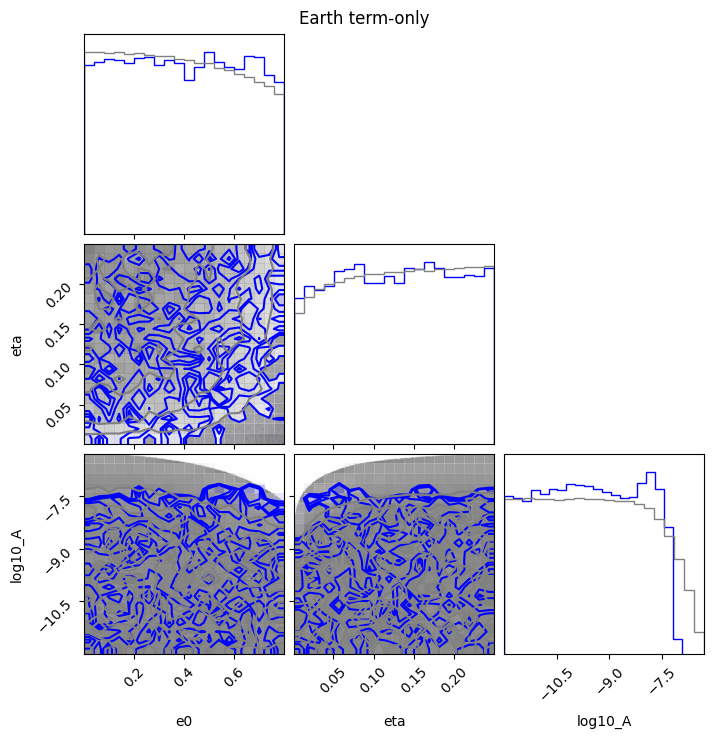

In [50]:
fig = corner.corner(chain_e_df_sel, color="blue", hist_kwargs={"density":True})
fig = corner.corner(prior_chain, labels=["e0", "eta", "log10_A"], color="grey", hist_kwargs={"density":True}, fig=fig)
plt.suptitle("Earth term-only")
# fig = corner.corner(chain_e_df_sel, fig=fig, color="blue", hist_kwargs={"density":True})

Text(0.5, 0.98, 'Earth+Pulsar term')

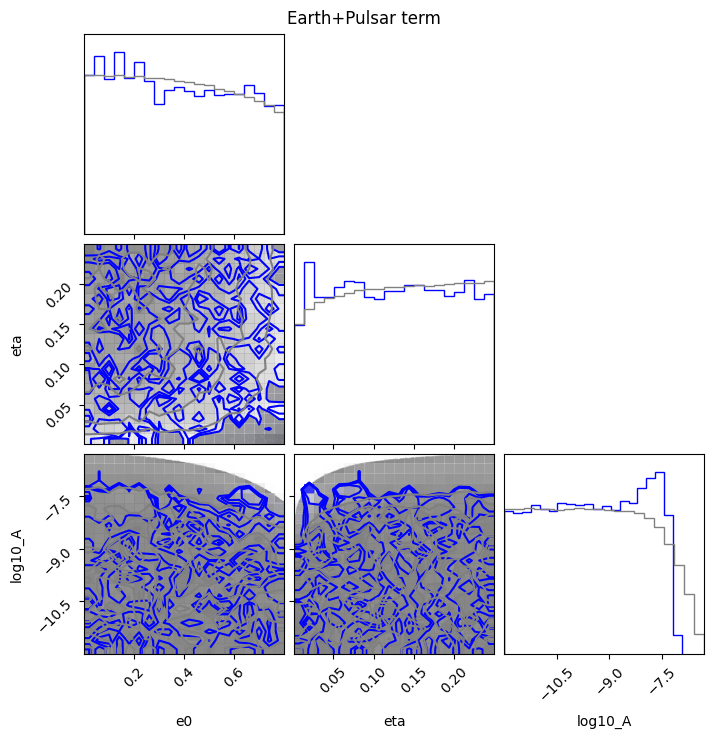

In [53]:
fig = corner.corner(chain_ep_df_sel, color="blue", hist_kwargs={"density":True})
fig = corner.corner(prior_chain, labels=["e0", "eta", "log10_A"], color="grey", hist_kwargs={"density":True}, fig=fig)
plt.suptitle("Earth+Pulsar term")
# fig = corner.corner(chain_e_df_sel, fig=fig, color="blue", hist_kwargs={"density":True})

In [54]:
prior_chain_df_trim = prior_chain_df.query("gwecc_eta>0.1 and gwecc_e0<0.5")
chain_e_df_trim = chain_e_df_sel.query("gwecc_eta>0.1 and gwecc_e0<0.5")
chain_ep_df_trim = chain_ep_df_sel.query("gwecc_eta>0.1 and gwecc_e0<0.5")

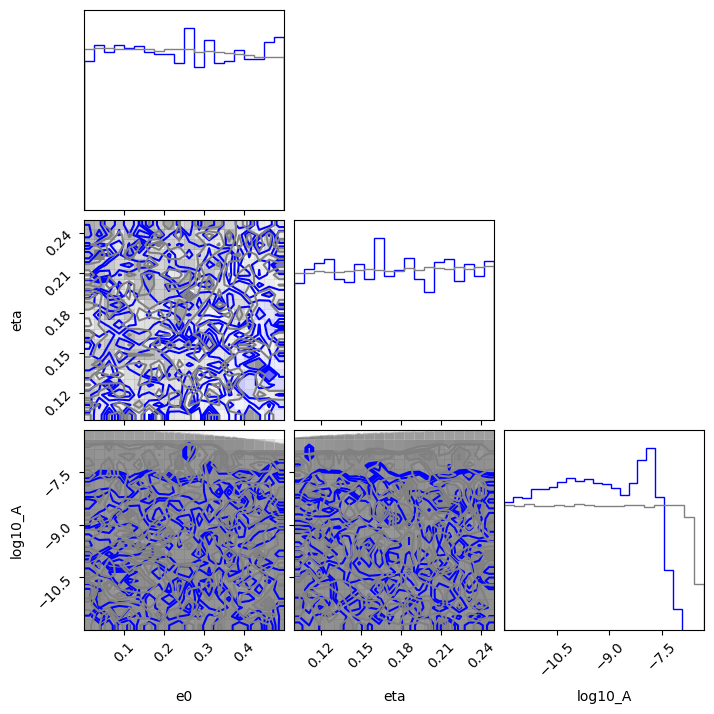

In [41]:
fig = corner.corner(chain_e_df_trim, color="blue", hist_kwargs={"density":True})
fig = corner.corner(prior_chain_df_trim, labels=["e0", "eta", "log10_A"], color="grey", hist_kwargs={"density":True}, fig=fig)

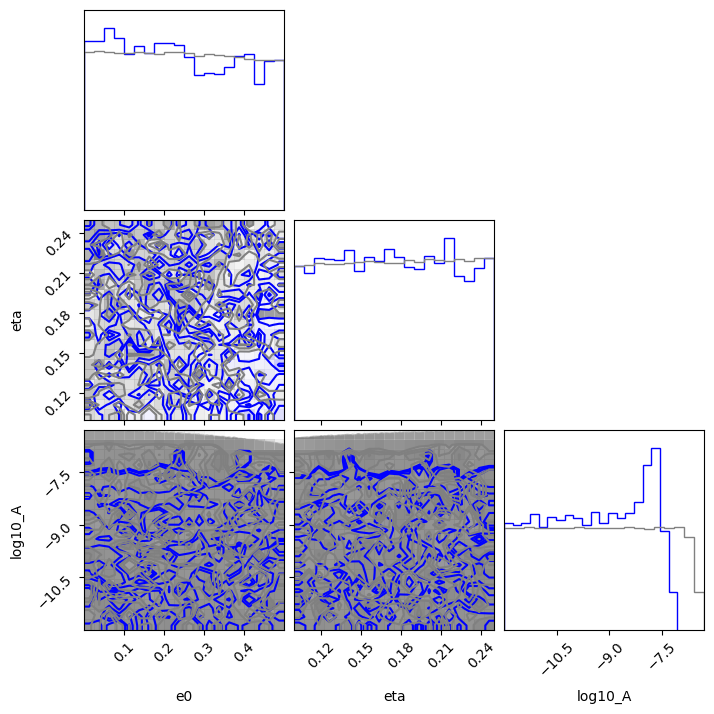

In [55]:
fig = corner.corner(chain_ep_df_trim, color="blue", hist_kwargs={"density":True})
fig = corner.corner(prior_chain_df_trim, labels=["e0", "eta", "log10_A"], color="grey", hist_kwargs={"density":True}, fig=fig)

In [49]:
prior_trim_hist0 = np.histogram(prior_chain_df_trim["gwecc_log10_A"], bins=12, density=True)[0][0]
posterior_trim_hist0 = np.histogram(chain_e_df_trim["gwecc_log10_A"], bins=12, density=True)[0][0]
bf_all = prior_trim_hist0/posterior_trim_hist0
print("Overall SD BF (E) =", bf_all)

Overall SD BF = 0.9397206402949689


In [56]:
prior_trim_hist0 = np.histogram(prior_chain_df_trim["gwecc_log10_A"], bins=12, density=True)[0][0]
posterior_trim_hist0 = np.histogram(chain_ep_df_trim["gwecc_log10_A"], bins=12, density=True)[0][0]
bf_all = prior_trim_hist0/posterior_trim_hist0
print("Overall SD BF (E+P) =", bf_all)

Overall SD BF (E+P) = 0.9514661848626849


In [57]:
e0_nbins = 8
eta_nbins = 8

e0_bins = np.linspace(0.01, 0.8, e0_nbins+1)
eta_bins = np.linspace(0.01, 0.25, eta_nbins+1)

In [67]:
bf_sd_e = np.empty((e0_nbins, eta_nbins))
log10_A_95u_post = np.empty((e0_nbins, eta_nbins))
log10_A_95u_prior = np.empty((e0_nbins, eta_nbins))
valid = np.empty((e0_nbins, eta_nbins))
for idx, (e0a, e0b) in enumerate(zip(e0_bins[:-1], e0_bins[1:])):
    for jdx, (etaa, etab) in enumerate(zip(eta_bins[:-1], eta_bins[1:])):
        query = f"{e0a}<=gwecc_e0<{e0b} and {etaa}<=gwecc_eta<{etab}"
        log10_A_bin_post = np.array(chain_e_df_sel.query(query)["gwecc_log10_A"])
        log10_A_bin_prior = np.array(prior_chain_df.query(query)["gwecc_log10_A"])
        log10_A_bin_prior_hist0 = np.histogram(log10_A_bin_prior, bins=12, density=True)[0][0]
        log10_A_bin_post_hist0 = np.histogram(log10_A_bin_post, bins=12, density=True)[0][0]
        bf_sd_e[idx, jdx] = log10_A_bin_prior_hist0 / log10_A_bin_post_hist0

        log10_A_95u_post[idx, jdx] = wquantiles.quantile(
            log10_A_bin_post, 
            log2linear_weight(log10_A_bin_post, -12, -6), 
            0.95
        )
        log10_A_95u_prior[idx, jdx] = wquantiles.quantile(
            log10_A_bin_prior, 
            log2linear_weight(log10_A_bin_prior, -12, -6), 
            0.95
        )
        valid[idx, jdx] = ((log10_A_95u_post[idx, jdx] - log10_A_95u_prior[idx, jdx]) / log10_A_95u_prior[idx, jdx]) > 0.05

In [71]:
# im = plt.imshow(bf_sd_e.T, origin="lower", cmap="hot", extent=(0.01, 0.8, 0.01, 0.25), aspect="auto")
# plt.colorbar(im)
# plt.xlabel("$e_0$")
# plt.ylabel("$\\eta$")

# for idx,e0 in enumerate((e0_bins[:-1]+e0_bins[1:])/2):
#     for jdx,eta in enumerate((eta_bins[:-1]+eta_bins[1:])/2):
#         plt.text(e0, eta, np.round(bf_sd_e[idx,jdx],1), ha="center", va="center", color="blue")

# plt.title("Earth term-only")

Text(0.5, 1.0, 'Earth term-only')

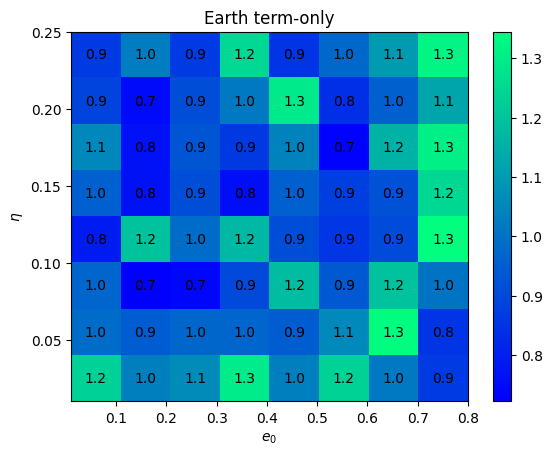

In [70]:
im = plt.imshow(bf_sd_e.T, origin="lower", cmap="winter", extent=(0.01, 0.8, 0.01, 0.25), aspect="auto")
plt.colorbar(im)
plt.xlabel("$e_0$")
plt.ylabel("$\\eta$")

for idx,e0 in enumerate((e0_bins[:-1]+e0_bins[1:])/2):
    for jdx,eta in enumerate((eta_bins[:-1]+eta_bins[1:])/2):
        color = "black" # if valid[idx, jdx] else "red"
        plt.text(e0, eta, np.round(bf_sd_e[idx,jdx],1), ha="center", va="center", color=color)

plt.title("Earth term-only")

In [72]:
bf_sd_ep = np.empty((e0_nbins, eta_nbins))
log10_A_95u_post = np.empty((e0_nbins, eta_nbins))
log10_A_95u_prior = np.empty((e0_nbins, eta_nbins))
valid = np.empty((e0_nbins, eta_nbins))
for idx, (e0a, e0b) in enumerate(zip(e0_bins[:-1], e0_bins[1:])):
    for jdx, (etaa, etab) in enumerate(zip(eta_bins[:-1], eta_bins[1:])):
        query = f"{e0a}<=gwecc_e0<{e0b} and {etaa}<=gwecc_eta<{etab}"
        log10_A_bin_post = np.array(chain_ep_df_sel.query(query)["gwecc_log10_A"])
        log10_A_bin_prior = np.array(prior_chain_df.query(query)["gwecc_log10_A"])
        log10_A_bin_prior_hist0 = np.histogram(log10_A_bin_prior, bins=12, density=True)[0][0]
        log10_A_bin_post_hist0 = np.histogram(log10_A_bin_post, bins=12, density=True)[0][0]
        bf_sd_ep[idx, jdx] = log10_A_bin_prior_hist0 / log10_A_bin_post_hist0

        # log10_A_95u_post[idx, jdx] = wquantiles.quantile(
        #     log10_A_bin_post, 
        #     log2linear_weight(log10_A_bin_post, -12, -6), 
        #     0.95
        # )
        # log10_A_95u_prior[idx, jdx] = wquantiles.quantile(
        #     log10_A_bin_prior, 
        #     log2linear_weight(log10_A_bin_prior, -12, -6), 
        #     0.95
        # )
        # valid[idx, jdx] = ((log10_A_95u_post[idx, jdx] - log10_A_95u_prior[idx, jdx]) / log10_A_95u_prior[idx, jdx]) > 0.05

Text(0.5, 1.0, 'Earth+Pulsar term')

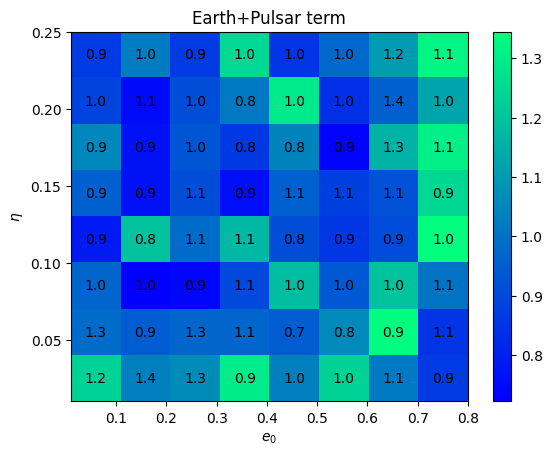

In [74]:
im = plt.imshow(bf_sd_e.T, origin="lower", cmap="winter", extent=(0.01, 0.8, 0.01, 0.25), aspect="auto")
plt.colorbar(im)
plt.xlabel("$e_0$")
plt.ylabel("$\\eta$")

for idx,e0 in enumerate((e0_bins[:-1]+e0_bins[1:])/2):
    for jdx,eta in enumerate((eta_bins[:-1]+eta_bins[1:])/2):
        color = "black" # if valid[idx, jdx] else "red"
        plt.text(e0, eta, np.round(bf_sd_ep[idx,jdx],1), ha="center", va="center", color=color)

plt.title("Earth+Pulsar term")